In [57]:
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결

from torch.nn import Transformer
from torch import nn
import torch
import math
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_percentage_error ,mean_squared_error

/Users/youngseoklee/opt/anaconda3/envs/ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
train_df = pd.read_csv('final_data.csv',index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

In [12]:
train_df.shape, y_test.shape

((547521, 11), (2016, 2))

In [9]:
cols = list(train_df.keys())
cols

['기온(°C)',
 '강수량(mm)',
 '풍속(m/s)',
 '습도(%)',
 '현지기압(hPa)',
 '일조(hr)',
 '일사(MJ/m2)',
 '적설(cm)',
 '전운량(10분위)',
 '지면온도(°C)',
 '현재수요(MW)']

In [13]:
y_test.tail()

,기준일시,현재수요(MW)
1134732,2023-03-19 23:35:00,58627.16
1134733,2023-03-19 23:40:00,57941.24
1134734,2023-03-19 23:45:00,57726.21
1134735,2023-03-19 23:50:00,57755.40
1134736,2023-03-19 23:55:00,57323.79


In [24]:
train_df.tail()

,기온(°C),강수량(mm),풍속(m/s),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C),현재수요(MW)
2023-03-19 23:35:00,4.946842,0.0,0.862368,68.204386,1006.203070,0.08617,0.060784,0.0,2.612281,3.775088,58627.16
2023-03-19 23:40:00,4.870526,0.0,0.864211,68.477193,1006.187719,0.08617,0.060784,0.0,2.645614,3.722807,57941.24
2023-03-19 23:45:00,4.794211,0.0,0.866053,68.750000,1006.172368,0.08617,0.060784,0.0,2.678947,3.670526,57726.21
2023-03-19 23:50:00,4.717895,0.0,0.867895,69.022807,1006.157018,0.08617,0.060784,0.0,2.712281,3.618246,57755.40
2023-03-19 23:55:00,4.641579,0.0,0.869737,69.295614,1006.141667,0.08617,0.060784,0.0,2.745614,3.565965,57323.79


In [42]:
train = train_df.loc[:'2023-03-16']
test = train_df.loc['2023-03-16':'2023-03-20']

In [43]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]


X_test = test.iloc[: ,:-1]
y_test = test.iloc[:, -1]

In [47]:
X.shape, y.shape, X_test.shape, y_test.shape

((546369, 10), (546369,), (1152, 10), (1152,))

# Preprocessing

In [48]:
#scailing

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()


X_scaled = min_max_scaler.fit_transform(X.to_numpy())
X_test_scaled = min_max_scaler.fit_transform(X_test.to_numpy())

In [49]:
X_train , X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=20, shuffle=False)

# LGBM

In [91]:
# Create a lgb.Dataset for both training and testing
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mape',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,  # Set feature_pre_filter to False
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'max_depth': trial.suggest_int('max_depth', 32, 64),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }


    gbm = lgb.train(params, lgb_train, 
                    valid_sets=lgb_eval,
                    num_boost_round=1000,
                   early_stopping_rounds=10)
    preds = gbm.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, preds)
    return mape


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2023-07-09 19:45:20,661] A new study created in memory with name: no-name-47b8510c-00f2-4fd2-915e-774c38d525df
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This fe

[1]	valid_0's mape: 0.109718
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107051
[3]	valid_0's mape: 0.10524
[4]	valid_0's mape: 0.10386
[5]	valid_0's mape: 0.102737
[6]	valid_0's mape: 0.100984
[7]	valid_0's mape: 0.0992789
[8]	valid_0's mape: 0.0986773
[9]	valid_0's mape: 0.0979234
[10]	valid_0's mape: 0.0973025
[11]	valid_0's mape: 0.0969904
[12]	valid_0's mape: 0.0967865
[13]	valid_0's mape: 0.0967786
[14]	valid_0's mape: 0.0965908
[15]	valid_0's mape: 0.0958683
[16]	valid_0's mape: 0.095891
[17]	valid_0's mape: 0.0953836
[18]	valid_0's mape: 0.0954088
[19]	valid_0's mape: 0.0950268
[20]	valid_0's mape: 0.0945987
[21]	valid_0's mape: 0.0942361
[22]	valid_0's mape: 0.0943609
[23]	valid_0's mape: 0.0943851
[24]	valid_0's mape: 0.0941165
[25]	valid_0's mape: 0.0941613
[26]	valid_0's mape: 0.0940053
[27]	valid_0's mape: 0.0941524
[28]	valid_0's mape: 0.0941858
[29]	valid_0's mape: 0.0942389
[30]	valid_0's mape: 0.0943347
[31]	valid_0's mape: 0.0941

[I 2023-07-09 19:45:21,590] Trial 0 finished with value: 0.2738282645184963 and parameters: {'lambda_l1': 0.03790607931275354, 'lambda_l2': 0.24098947496433618, 'max_depth': 64, 'num_leaves': 57, 'feature_fraction': 0.9353602854426868, 'bagging_fraction': 0.8835155085765161, 'bagging_freq': 3, 'min_child_samples': 75}. Best is trial 0 with value: 0.2738282645184963.


[34]	valid_0's mape: 0.0938334
[35]	valid_0's mape: 0.0939112
[36]	valid_0's mape: 0.0938607
[37]	valid_0's mape: 0.0942761
[38]	valid_0's mape: 0.0946741
[39]	valid_0's mape: 0.094603
[40]	valid_0's mape: 0.0946064
[41]	valid_0's mape: 0.0946647
[42]	valid_0's mape: 0.0943735
[43]	valid_0's mape: 0.0942978
Early stopping, best iteration is:
[33]	valid_0's mape: 0.0937997
[1]	valid_0's mape: 0.109628
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.108372


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.107344
[4]	valid_0's mape: 0.106787
[5]	valid_0's mape: 0.104754
[6]	valid_0's mape: 0.104255
[7]	valid_0's mape: 0.104095
[8]	valid_0's mape: 0.102731
[9]	valid_0's mape: 0.101671
[10]	valid_0's mape: 0.101531
[11]	valid_0's mape: 0.100723
[12]	valid_0's mape: 0.100776
[13]	valid_0's mape: 0.100103
[14]	valid_0's mape: 0.0993367
[15]	valid_0's mape: 0.0985331
[16]	valid_0's mape: 0.0982172
[17]	valid_0's mape: 0.097695
[18]	valid_0's mape: 0.0971409
[19]	valid_0's mape: 0.0968837
[20]	valid_0's mape: 0.0963623
[21]	valid_0's mape: 0.0959241
[22]	valid_0's mape: 0.0956892
[23]	valid_0's mape: 0.095455
[24]	valid_0's mape: 0.0951702
[25]	valid_0's mape: 0.0948367
[26]	valid_0's mape: 0.0947548
[27]	valid_0's mape: 0.094574
[28]	valid_0's mape: 0.0944425
[29]	valid_0's mape: 0.0942756
[30]	valid_0's mape: 0.0939664


[I 2023-07-09 19:45:21,944] Trial 1 finished with value: 0.2667588731523868 and parameters: {'lambda_l1': 0.0010178472949287998, 'lambda_l2': 6.094223074108257e-07, 'max_depth': 42, 'num_leaves': 13, 'feature_fraction': 0.9362140453986392, 'bagging_fraction': 0.4715116889161418, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 1 with value: 0.2667588731523868.


[31]	valid_0's mape: 0.0937764
[32]	valid_0's mape: 0.0935717
[33]	valid_0's mape: 0.0933293
[34]	valid_0's mape: 0.0931334
[35]	valid_0's mape: 0.0930158
[36]	valid_0's mape: 0.0929508
[37]	valid_0's mape: 0.0928273
[38]	valid_0's mape: 0.0930089
[39]	valid_0's mape: 0.0929913
[40]	valid_0's mape: 0.0931398
[41]	valid_0's mape: 0.0934069
[42]	valid_0's mape: 0.0933509
[43]	valid_0's mape: 0.0932573
[44]	valid_0's mape: 0.0931505
[45]	valid_0's mape: 0.0930343
[46]	valid_0's mape: 0.0929319
[47]	valid_0's mape: 0.0929219
Early stopping, best iteration is:
[37]	valid_0's mape: 0.0928273
[1]	valid_0's mape: 0.109244
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107045


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.105546
[4]	valid_0's mape: 0.104325
[5]	valid_0's mape: 0.101816
[6]	valid_0's mape: 0.0999324
[7]	valid_0's mape: 0.099762
[8]	valid_0's mape: 0.0981271
[9]	valid_0's mape: 0.0970321
[10]	valid_0's mape: 0.0961251
[11]	valid_0's mape: 0.0959141
[12]	valid_0's mape: 0.0948215
[13]	valid_0's mape: 0.0946404
[14]	valid_0's mape: 0.0941007
[15]	valid_0's mape: 0.0934184
[16]	valid_0's mape: 0.0929881
[17]	valid_0's mape: 0.0925873
[18]	valid_0's mape: 0.0922524
[19]	valid_0's mape: 0.091797
[20]	valid_0's mape: 0.0913214
[21]	valid_0's mape: 0.0910795
[22]	valid_0's mape: 0.0907938
[23]	valid_0's mape: 0.0907769
[24]	valid_0's mape: 0.0905341
[25]	valid_0's mape: 0.0904819
[26]	valid_0's mape: 0.0905839
[27]	valid_0's mape: 0.0904493
[28]	valid_0's mape: 0.0904467
[29]	valid_0's mape: 0.090236
[30]	valid_0's mape: 0.0906598
[31]	valid_0's mape: 0.0905437
[32]	valid_0's mape: 0.0904162
[33]	valid_0's mape: 0.0903228
[34]	valid_0's mape: 0.0903122
[35]	valid_0's mape: 

[I 2023-07-09 19:45:23,141] Trial 2 finished with value: 0.257632544654609 and parameters: {'lambda_l1': 1.653825129470756e-08, 'lambda_l2': 0.0026293660043523012, 'max_depth': 51, 'num_leaves': 71, 'feature_fraction': 0.4771304587688676, 'bagging_fraction': 0.726620293743558, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial 2 with value: 0.257632544654609.


[47]	valid_0's mape: 0.0904813
[48]	valid_0's mape: 0.0904693
[49]	valid_0's mape: 0.0905208
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0899338
[1]	valid_0's mape: 0.109953
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107115


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.105078
[4]	valid_0's mape: 0.104056
[5]	valid_0's mape: 0.102739
[6]	valid_0's mape: 0.100715
[7]	valid_0's mape: 0.0990872
[8]	valid_0's mape: 0.0975666
[9]	valid_0's mape: 0.0965933
[10]	valid_0's mape: 0.0960074
[11]	valid_0's mape: 0.0958269
[12]	valid_0's mape: 0.0949942
[13]	valid_0's mape: 0.0947425
[14]	valid_0's mape: 0.0945078
[15]	valid_0's mape: 0.0942673
[16]	valid_0's mape: 0.0940765
[17]	valid_0's mape: 0.0937342
[18]	valid_0's mape: 0.0933132
[19]	valid_0's mape: 0.0930122
[20]	valid_0's mape: 0.092673
[21]	valid_0's mape: 0.0923738
[22]	valid_0's mape: 0.0923751
[23]	valid_0's mape: 0.0923597
[24]	valid_0's mape: 0.0921893
[25]	valid_0's mape: 0.0921835
[26]	valid_0's mape: 0.0922296
[27]	valid_0's mape: 0.0922613
[28]	valid_0's mape: 0.092477
[29]	valid_0's mape: 0.0923984
[30]	valid_0's mape: 0.0926085
[31]	valid_0's mape: 0.0925634
[32]	valid_0's mape: 0.0924576
[33]	valid_0's mape: 0.0924792
[34]	valid_0's mape: 0.0925211


[I 2023-07-09 19:45:25,010] Trial 3 finished with value: 0.2253523115350207 and parameters: {'lambda_l1': 2.17697874154849e-05, 'lambda_l2': 3.130718353792824e-06, 'max_depth': 48, 'num_leaves': 219, 'feature_fraction': 0.7532875164387152, 'bagging_fraction': 0.7279874837206397, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 3 with value: 0.2253523115350207.


[35]	valid_0's mape: 0.0924942
Early stopping, best iteration is:
[25]	valid_0's mape: 0.0921835
[1]	valid_0's mape: 0.110293
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107649
[3]	valid_0's mape: 0.105785


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[4]	valid_0's mape: 0.104846
[5]	valid_0's mape: 0.102343
[6]	valid_0's mape: 0.100346
[7]	valid_0's mape: 0.0997339
[8]	valid_0's mape: 0.0981072
[9]	valid_0's mape: 0.0977425
[10]	valid_0's mape: 0.0972276
[11]	valid_0's mape: 0.0971038
[12]	valid_0's mape: 0.0961997
[13]	valid_0's mape: 0.0960765
[14]	valid_0's mape: 0.0961304
[15]	valid_0's mape: 0.0958667
[16]	valid_0's mape: 0.0957713
[17]	valid_0's mape: 0.0954897
[18]	valid_0's mape: 0.0954016
[19]	valid_0's mape: 0.0949663
[20]	valid_0's mape: 0.0946071
[21]	valid_0's mape: 0.0942065
[22]	valid_0's mape: 0.0945745
[23]	valid_0's mape: 0.0948386
[24]	valid_0's mape: 0.0945255
[25]	valid_0's mape: 0.0945096
[26]	valid_0's mape: 0.0942061
[27]	valid_0's mape: 0.0944375
[28]	valid_0's mape: 0.0945836
[29]	valid_0's mape: 0.0945978
[30]	valid_0's mape: 0.0946968
[31]	valid_0's mape: 0.0947716
[32]	valid_0's mape: 0.0946215
[33]	valid_0's mape: 0.0946836


[I 2023-07-09 19:45:26,898] Trial 4 finished with value: 0.2678020385254172 and parameters: {'lambda_l1': 4.2011681514245673e-08, 'lambda_l2': 5.463280221232775, 'max_depth': 58, 'num_leaves': 216, 'feature_fraction': 0.7091026211700586, 'bagging_fraction': 0.5946041354682225, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 3 with value: 0.2253523115350207.


[34]	valid_0's mape: 0.0944685
[35]	valid_0's mape: 0.0944081
[36]	valid_0's mape: 0.0944019
Early stopping, best iteration is:
[26]	valid_0's mape: 0.0942061
[1]	valid_0's mape: 0.109452
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107301
[3]	valid_0's mape: 0.106056
[4]	valid_0's mape: 0.104918
[5]	valid_0's mape: 0.102482


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[6]	valid_0's mape: 0.10067
[7]	valid_0's mape: 0.100463
[8]	valid_0's mape: 0.098867
[9]	valid_0's mape: 0.0977499
[10]	valid_0's mape: 0.0968079
[11]	valid_0's mape: 0.0967656
[12]	valid_0's mape: 0.0957722
[13]	valid_0's mape: 0.0957833
[14]	valid_0's mape: 0.0951872
[15]	valid_0's mape: 0.0944611
[16]	valid_0's mape: 0.093999
[17]	valid_0's mape: 0.0935651
[18]	valid_0's mape: 0.0933122
[19]	valid_0's mape: 0.0928491
[20]	valid_0's mape: 0.0923298
[21]	valid_0's mape: 0.0920321
[22]	valid_0's mape: 0.0917649
[23]	valid_0's mape: 0.0917312
[24]	valid_0's mape: 0.0914381
[25]	valid_0's mape: 0.0915195
[26]	valid_0's mape: 0.0917068
[27]	valid_0's mape: 0.0913482
[28]	valid_0's mape: 0.0912445
[29]	valid_0's mape: 0.0909948
[30]	valid_0's mape: 0.0912137
[31]	valid_0's mape: 0.0910673
[32]	valid_0's mape: 0.0909332
[33]	valid_0's mape: 0.0908197
[34]	valid_0's mape: 0.0907366
[35]	valid_0's mape: 0.0906328
[36]	valid_0's mape: 0.0905156
[37]	valid_0's mape: 0.0906852
[38]	valid_0's ma

[I 2023-07-09 19:45:27,632] Trial 5 finished with value: 0.2771427711800327 and parameters: {'lambda_l1': 0.035667904573496556, 'lambda_l2': 0.002368501586536577, 'max_depth': 41, 'num_leaves': 38, 'feature_fraction': 0.530405257031284, 'bagging_fraction': 0.4863043552032533, 'bagging_freq': 2, 'min_child_samples': 85}. Best is trial 3 with value: 0.2253523115350207.


[49]	valid_0's mape: 0.091071
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0904271
[1]	valid_0's mape: 0.108926
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106646
[3]	valid_0's mape: 0.105261


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[4]	valid_0's mape: 0.104895
[5]	valid_0's mape: 0.102281
[6]	valid_0's mape: 0.100304
[7]	valid_0's mape: 0.099534
[8]	valid_0's mape: 0.0979066
[9]	valid_0's mape: 0.0966677
[10]	valid_0's mape: 0.0953856
[11]	valid_0's mape: 0.0946942
[12]	valid_0's mape: 0.0937646
[13]	valid_0's mape: 0.0935504
[14]	valid_0's mape: 0.0929138
[15]	valid_0's mape: 0.092324
[16]	valid_0's mape: 0.0922249
[17]	valid_0's mape: 0.091723
[18]	valid_0's mape: 0.0917152
[19]	valid_0's mape: 0.0913513
[20]	valid_0's mape: 0.0910714
[21]	valid_0's mape: 0.0907746
[22]	valid_0's mape: 0.0905371
[23]	valid_0's mape: 0.0906728
[24]	valid_0's mape: 0.0904556
[25]	valid_0's mape: 0.0903472
[26]	valid_0's mape: 0.0904495
[27]	valid_0's mape: 0.0903678
[28]	valid_0's mape: 0.0904267
[29]	valid_0's mape: 0.0902489
[30]	valid_0's mape: 0.090396
[31]	valid_0's mape: 0.090304
[32]	valid_0's mape: 0.0902489
[33]	valid_0's mape: 0.09018
[34]	valid_0's mape: 0.0902839
[35]	valid_0's mape: 0.0902473
[36]	valid_0's mape: 0.0

[I 2023-07-09 19:45:30,118] Trial 6 finished with value: 0.25061595829818667 and parameters: {'lambda_l1': 3.8741953722146277e-07, 'lambda_l2': 0.0022494577727871154, 'max_depth': 43, 'num_leaves': 218, 'feature_fraction': 0.5835621722125707, 'bagging_fraction': 0.7664859790756664, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 3 with value: 0.2253523115350207.


[43]	valid_0's mape: 0.0903313
Early stopping, best iteration is:
[33]	valid_0's mape: 0.09018
[1]	valid_0's mape: 0.10987
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107082
[3]	valid_0's mape: 0.105153


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[4]	valid_0's mape: 0.104015
[5]	valid_0's mape: 0.101589
[6]	valid_0's mape: 0.0995491
[7]	valid_0's mape: 0.0986107
[8]	valid_0's mape: 0.0970727
[9]	valid_0's mape: 0.0966936
[10]	valid_0's mape: 0.0962554
[11]	valid_0's mape: 0.0955371
[12]	valid_0's mape: 0.0946831
[13]	valid_0's mape: 0.0944267
[14]	valid_0's mape: 0.0941008
[15]	valid_0's mape: 0.0941555
[16]	valid_0's mape: 0.0941285
[17]	valid_0's mape: 0.0938531
[18]	valid_0's mape: 0.0939176
[19]	valid_0's mape: 0.0935044
[20]	valid_0's mape: 0.0931476
[21]	valid_0's mape: 0.0928427
[22]	valid_0's mape: 0.0929687
[23]	valid_0's mape: 0.0931764
[24]	valid_0's mape: 0.0929464
[25]	valid_0's mape: 0.0930457
[26]	valid_0's mape: 0.0930837
[27]	valid_0's mape: 0.0931664


[I 2023-07-09 19:45:31,910] Trial 7 finished with value: 0.20697896466027813 and parameters: {'lambda_l1': 6.651330258402688e-07, 'lambda_l2': 2.1355684992216897e-07, 'max_depth': 41, 'num_leaves': 238, 'feature_fraction': 0.7113325455858996, 'bagging_fraction': 0.9281578428675564, 'bagging_freq': 2, 'min_child_samples': 91}. Best is trial 7 with value: 0.20697896466027813.


[28]	valid_0's mape: 0.0933492
[29]	valid_0's mape: 0.093541
[30]	valid_0's mape: 0.0934131
[31]	valid_0's mape: 0.0932295
Early stopping, best iteration is:
[21]	valid_0's mape: 0.0928427


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.109965
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107159
[3]	valid_0's mape: 0.105398
[4]	valid_0's mape: 0.10435
[5]	valid_0's mape: 0.101957
[6]	valid_0's mape: 0.0999963
[7]	valid_0's mape: 0.0983821
[8]	valid_0's mape: 0.09687
[9]	valid_0's mape: 0.0963266
[10]	valid_0's mape: 0.0960513
[11]	valid_0's mape: 0.0956458
[12]	valid_0's mape: 0.0950252
[13]	valid_0's mape: 0.0949032
[14]	valid_0's mape: 0.0946346
[15]	valid_0's mape: 0.0943714
[16]	valid_0's mape: 0.0942297
[17]	valid_0's mape: 0.0940445
[18]	valid_0's mape: 0.0936092
[19]	valid_0's mape: 0.0932069
[20]	valid_0's mape: 0.0929059
[21]	valid_0's mape: 0.092587
[22]	valid_0's mape: 0.0925832
[23]	valid_0's mape: 0.0927743
[24]	valid_0's mape: 0.0925671
[25]	valid_0's mape: 0.092525
[26]	valid_0's mape: 0.0925118
[27]	valid_0's mape: 0.0924335
[28]	valid_0's mape: 0.0924209
[29]	valid_0's mape: 0.0922994
[30]	valid_0's mape: 0.092145
[31]	valid_0's mape: 0.092105

[I 2023-07-09 19:45:33,747] Trial 8 finished with value: 0.2158894095508942 and parameters: {'lambda_l1': 0.024543680855258144, 'lambda_l2': 0.0016964265798478254, 'max_depth': 64, 'num_leaves': 139, 'feature_fraction': 0.847798151100774, 'bagging_fraction': 0.47978792056799296, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 7 with value: 0.20697896466027813.


[47]	valid_0's mape: 0.0918958
[48]	valid_0's mape: 0.0919082
[49]	valid_0's mape: 0.0919143
[50]	valid_0's mape: 0.0919542
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0914093
[1]	valid_0's mape: 0.10985
Training until validation scores don't improve for 10 rounds


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_66183/4076900590.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[2]	valid_0's mape: 0.106925
[3]	valid_0's mape: 0.105361
[4]	valid_0's mape: 0.104448
[5]	valid_0's mape: 0.101996
[6]	valid_0's mape: 0.10003
[7]	valid_0's mape: 0.0994648
[8]	valid_0's mape: 0.0979085
[9]	valid_0's mape: 0.0971376
[10]	valid_0's mape: 0.0965994
[11]	valid_0's mape: 0.0962608
[12]	valid_0's mape: 0.0953904
[13]	valid_0's mape: 0.0951228
[14]	valid_0's mape: 0.0949667
[15]	valid_0's mape: 0.0946747
[16]	valid_0's mape: 0.094621
[17]	valid_0's mape: 0.0942966
[18]	valid_0's mape: 0.0941572
[19]	valid_0's mape: 0.0937532
[20]	valid_0's mape: 0.093382
[21]	valid_0's mape: 0.0930532
[22]	valid_0's mape: 0.0931971
[23]	valid_0's mape: 0.0931433
[24]	valid_0's mape: 0.0929201
[25]	valid_0's mape: 0.0929915
[26]	valid_0's mape: 0.0930654
[27]	valid_0's mape: 0.0930305
[28]	valid_0's mape: 0.0930646
[29]	valid_0's mape: 0.0931029
[30]	valid_0's mape: 0.0931449
[31]	valid_0's mape: 0.0930287
[32]	valid_0's mape: 0.0929425
[33]	valid_0's mape: 0.0928909
[34]	valid_0's mape: 0.0

[I 2023-07-09 19:45:36,054] Trial 9 finished with value: 0.23007686954807852 and parameters: {'lambda_l1': 0.00011476065137324074, 'lambda_l2': 1.0649912017444818e-08, 'max_depth': 34, 'num_leaves': 218, 'feature_fraction': 0.7021287732641976, 'bagging_fraction': 0.42096549832946173, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 7 with value: 0.20697896466027813.


Best trial:
  Value: 0.20697896466027813
  Params: 
    lambda_l1: 6.651330258402688e-07
    lambda_l2: 2.1355684992216897e-07
    max_depth: 41
    num_leaves: 238
    feature_fraction: 0.7113325455858996
    bagging_fraction: 0.9281578428675564
    bagging_freq: 2
    min_child_samples: 91


In [ ]:
'''
Best trial:
  Value: 0.20697896466027813
  Params: 
    lambda_l1: 6.651330258402688e-07
    lambda_l2: 2.1355684992216897e-07
    max_depth: 41
    num_leaves: 238
    feature_fraction: 0.7113325455858996
    bagging_fraction: 0.9281578428675564
    bagging_freq: 2
    min_child_samples: 91
'''

In [93]:

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',   # Use 'regression' for regression task
    'metric': 'mape',            # Root mean squared error
    'lambda_l1': 6.651330258402688e-07,
    'lambda_l2': 2.1355684992216897e-07,
    'num_leaves': 238,
    'max_depth' : 41,
    'learning_rate': 0.05,
    'feature_fraction': 0.7113325455858996,
    'bagging_fraction': 0.9281578428675564,
    'bagging_freq': 2,
    'verbose': 0,
    'min_child_samples': 91
}

# Train the model
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=10)

# Predict on your test set
preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)
mape = mean_absolute_percentage_error(y_test, preds)

/Users/youngseoklee/opt/anaconda3/envs/ai/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's mape: 0.111413
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.109721
[3]	valid_0's mape: 0.108593
[4]	valid_0's mape: 0.108016
[5]	valid_0's mape: 0.106374
[6]	valid_0's mape: 0.104876
[7]	valid_0's mape: 0.104195
[8]	valid_0's mape: 0.102868
[9]	valid_0's mape: 0.102377
[10]	valid_0's mape: 0.101707
[11]	valid_0's mape: 0.101315
[12]	valid_0's mape: 0.100346
[13]	valid_0's mape: 0.0999859
[14]	valid_0's mape: 0.0994667
[15]	valid_0's mape: 0.0990503
[16]	valid_0's mape: 0.0988167
[17]	valid_0's mape: 0.0985921
[18]	valid_0's mape: 0.0982016
[19]	valid_0's mape: 0.0975561
[20]	valid_0's mape: 0.096985
[21]	valid_0's mape: 0.0964204
[22]	valid_0's mape: 0.096267
[23]	valid_0's mape: 0.0961326
[24]	valid_0's mape:

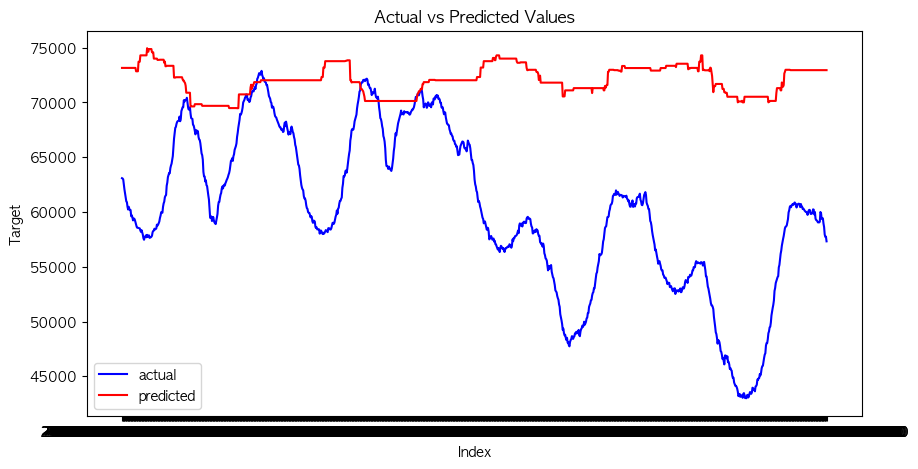

In [94]:
# Now, we can create the plot
plt.figure(figsize=(10,5))

# Plot the actual values
plt.plot(y_test, 'b-', label='actual')

# Plot the predicted values
plt.plot(preds, 'r-', label='predicted')

# Create a legend
plt.legend()

# Add a title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Target')

# Show the plot
plt.show()

# Transformer

In [96]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [98]:
import torch
from torch.utils.data import Dataset
device = torch.device("mps")

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_length = sequence_length

    def __len__(self):
        return self.X.__len__() - self.seq_length #timeDAta에서 seq 길이를 뺀것이 무슨 의미가 있는거지

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_length], self.y[index+self.seq_length])

SEQUENCE_LENGTH = 10  # 이는 문제에 따라 조정해야 합니다.
N_FEATURES = 6


dataset = TimeSeriesDataset(X_train, y_train, SEQUENCE_LENGTH)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)



val_dataset = TimeSeriesDataset(X_val, y_val, SEQUENCE_LENGTH)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


In [120]:
torch.set_default_device('cpu')

In [125]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):

    def __init__(self, input_dim, output_dim, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(input_dim, dropout)
        encoder_layers = TransformerEncoderLayer(input_dim, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.decoder = nn.Linear(input_dim, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None):
        #src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src) 
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [126]:
torch.__version__

'2.0.0'

In [127]:
X_train.shape, y_train.shape

((437095, 10), (437095,))

In [ ]:
import torch.optim as optim

# Initialize model, loss, and optimizer
model = TransformerModel(input_dim=10, output_dim=1, nhead=2, nhid=16, nlayers=2)
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
def train_model(model, epochs):
    model.train()
    for epoch in range(epochs):
        for i, (x, y) in enumerate(dataloader): # assume train_loader is your DataLoader
            optimizer.zero_grad()
            x = x.transpose(0, 1) # Transform input to suitable shape
            output = model(x)
            loss = loss_fn(output[-1], y) # Compute loss
            loss.backward() # Compute gradients
            optimizer.step() # Update weights

        print(f'Epoch {epoch+1}/{epochs} Loss: {loss.item()}')

train_model(model, epochs=10)


/Users/youngseoklee/opt/anaconda3/envs/ai/lib/python3.10/site-packages/torch/utils/_device.py:62: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
/Users/youngseoklee/opt/anaconda3/envs/ai/lib/python3.10/site-packages/torch/utils/_device.py:62: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


Epoch 1/10 Loss: 102664880.0
Epoch 2/10 Loss: 101747296.0
Epoch 3/10 Loss: 102635512.0


In [89]:
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Don't track gradients
        for i, (x, y) in enumerate(dataloader):
            x = x.transpose(0, 1)
            output = model(x)
            loss = loss_fn(output[-1], y)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f'Average Loss: {avg_loss}')
    return avg_loss

# Suppose you have a validation or test dataloader, named val_loader or test_loader
evaluate_model(model, val_loader)


/Users/youngseoklee/opt/anaconda3/envs/ai/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Loss: 121836087.27469574


/Users/youngseoklee/opt/anaconda3/envs/ai/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


121836087.27469574